# Implementação GPU: Filtro Tons de Cinza para Imagens

No presente documento consta a implementação em CUDA de um filtro tons de cinza para imagens.

Este notebook apresenta duas implementações do filtro tons de cinza, uma sequencial em C++ e outra paralela utilizando programação CUDA.

Na literatura, existem diversas implementações desse filtro utilizando diferentes espaços de cor. A implementação aqui apresentada foi feita utilizando o espaço de cor Adobe RGB. É essencialmente feita uma ponderação dos componentes de cor por uma constante que representa o quão intensamente esse componente é perceptível no espectro visível de cor.

 - greyPixel = 0.21*r + 0.71*g + 0.07*b

Para ler e salvar os arquivos de imagem, é utilizado uma biblioteca auxiliar stb.

Também são utilizados alguns scripts em Python para tornar esse notebook autocontido. Com eles são feitas coisas como: verificar a presença de GPU, baixar imagens de uma lista de URLs e então apresentar essas imagens antes e depois do filtro tons de cinza.

##Preparando Ambiente

In [ ]:
# check for gpu
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# check for nvcc
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
# cloning library for image handling (reading/writing files)
!git clone https://github.com/nothings/stb
!ls

Cloning into 'stb'...
remote: Enumerating objects: 7247, done.
remote: Total 7247 (delta 0), reused 0 (delta 0), pack-reused 7247
Receiving objects: 100% (7247/7247), 4.89 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (4833/4833), done.
sample_data  stb


In [ ]:
# python script to download sample image
import requests

image_url_list = [
    'https://i.pinimg.com/originals/6d/d5/70/6dd570db68a8bec3ed51aa26146746fe.png',
    'https://c4.wallpaperflare.com/wallpaper/500/442/354/outrun-vaporwave-hd-wallpaper-preview.jpg',
    'https://ccs2.ufpel.edu.br/wp/wp-content/uploads/2019/06/DSC_0106-108.jpg',
    'https://i1.rgstatic.net/ii/profile.image/278775561506820-1443476681219_Q128/Gerson_Cavalheiro.jpg'
]

image_data_list = []

for url in image_url_list:
    image_data_list.append(requests.get(url).content)

for x, image in enumerate(image_data_list):
    format = image_url_list[x][-4:]
    image_name = 'example_image_' + str(x) + format
    with open(image_name, 'wb') as handler:
        handler.write(image)

## Implementação Sequencial

In [ ]:
%%writefile greyscale_serial.cpp

#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>

#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"


int main(int argc, char** argv) {
    if(argc < 3) {
        printf("Usage: ./greyscale_serial <input_image_file> <output_image_file.jpg>\n");
        exit(1);
    }

    // load image

    int width, height, channels, channels_try;
    
    channels_try = 3;

    uint8_t* img;
    
    img = stbi_load(argv[1], &width, &height, &channels, channels_try);

    if(channels != channels_try) {
        channels_try = 4;
        img = stbi_load(argv[1], &width, &height, &channels, channels_try);
    }

    size_t img_size = width * height * channels;
    
    printf("%d\t%d\t%d\n", width, height, channels);

    // allocate gray image

    int grey_channels;

    grey_channels = 1;

    size_t img_grey_size = width * height * grey_channels;
 
    unsigned char *img_grey = (unsigned char *) malloc(img_grey_size);
    if(img_grey == NULL) {
        printf("Unable to allocate memory for the gray image.\n");
        exit(1);
    }

    // calculate gray values
    
    unsigned char *pg;

    for(unsigned char *p = img, *pg = img_grey; p != (img + img_size); p += channels, pg += grey_channels) {
        *pg = (uint8_t)((*p + *(p + 1) + *(p + 2))/3.0);
        if(channels == 4) {
            *(pg + 1) = *(p + 3);
        }
    }

    // save grey image

    stbi_write_jpg(argv[2], width, height, grey_channels, img_grey, 100);

    // free image

    stbi_image_free(img);
    free(img_grey);

    return 0;
}

Writing greyscale_serial.cpp


In [ ]:
!g++ greyscale_serial.cpp -o greyscale_serial

In [ ]:
%%time
!./greyscale_serial example_image_0.png serial_grey_example_image_0.jpg

1920	1080	4
CPU times: user 5.34 ms, sys: 11.1 ms, total: 16.4 ms
Wall time: 831 ms


In [ ]:
%%time
!./greyscale_serial example_image_1.jpg serial_grey_example_image_1.jpg

728	410	3
CPU times: user 3.2 ms, sys: 9.98 ms, total: 13.2 ms
Wall time: 124 ms


In [ ]:
%%time
!./greyscale_serial example_image_2.jpg serial_grey_example_image_2.jpg

4288	2848	3
CPU times: user 7 ms, sys: 14 ms, total: 21 ms
Wall time: 2.33 s


In [ ]:
%%time
!./greyscale_serial example_image_3.jpg serial_grey_example_image_3.jpg

128	128	3
CPU times: user 2.59 ms, sys: 10.5 ms, total: 13.1 ms
Wall time: 125 ms


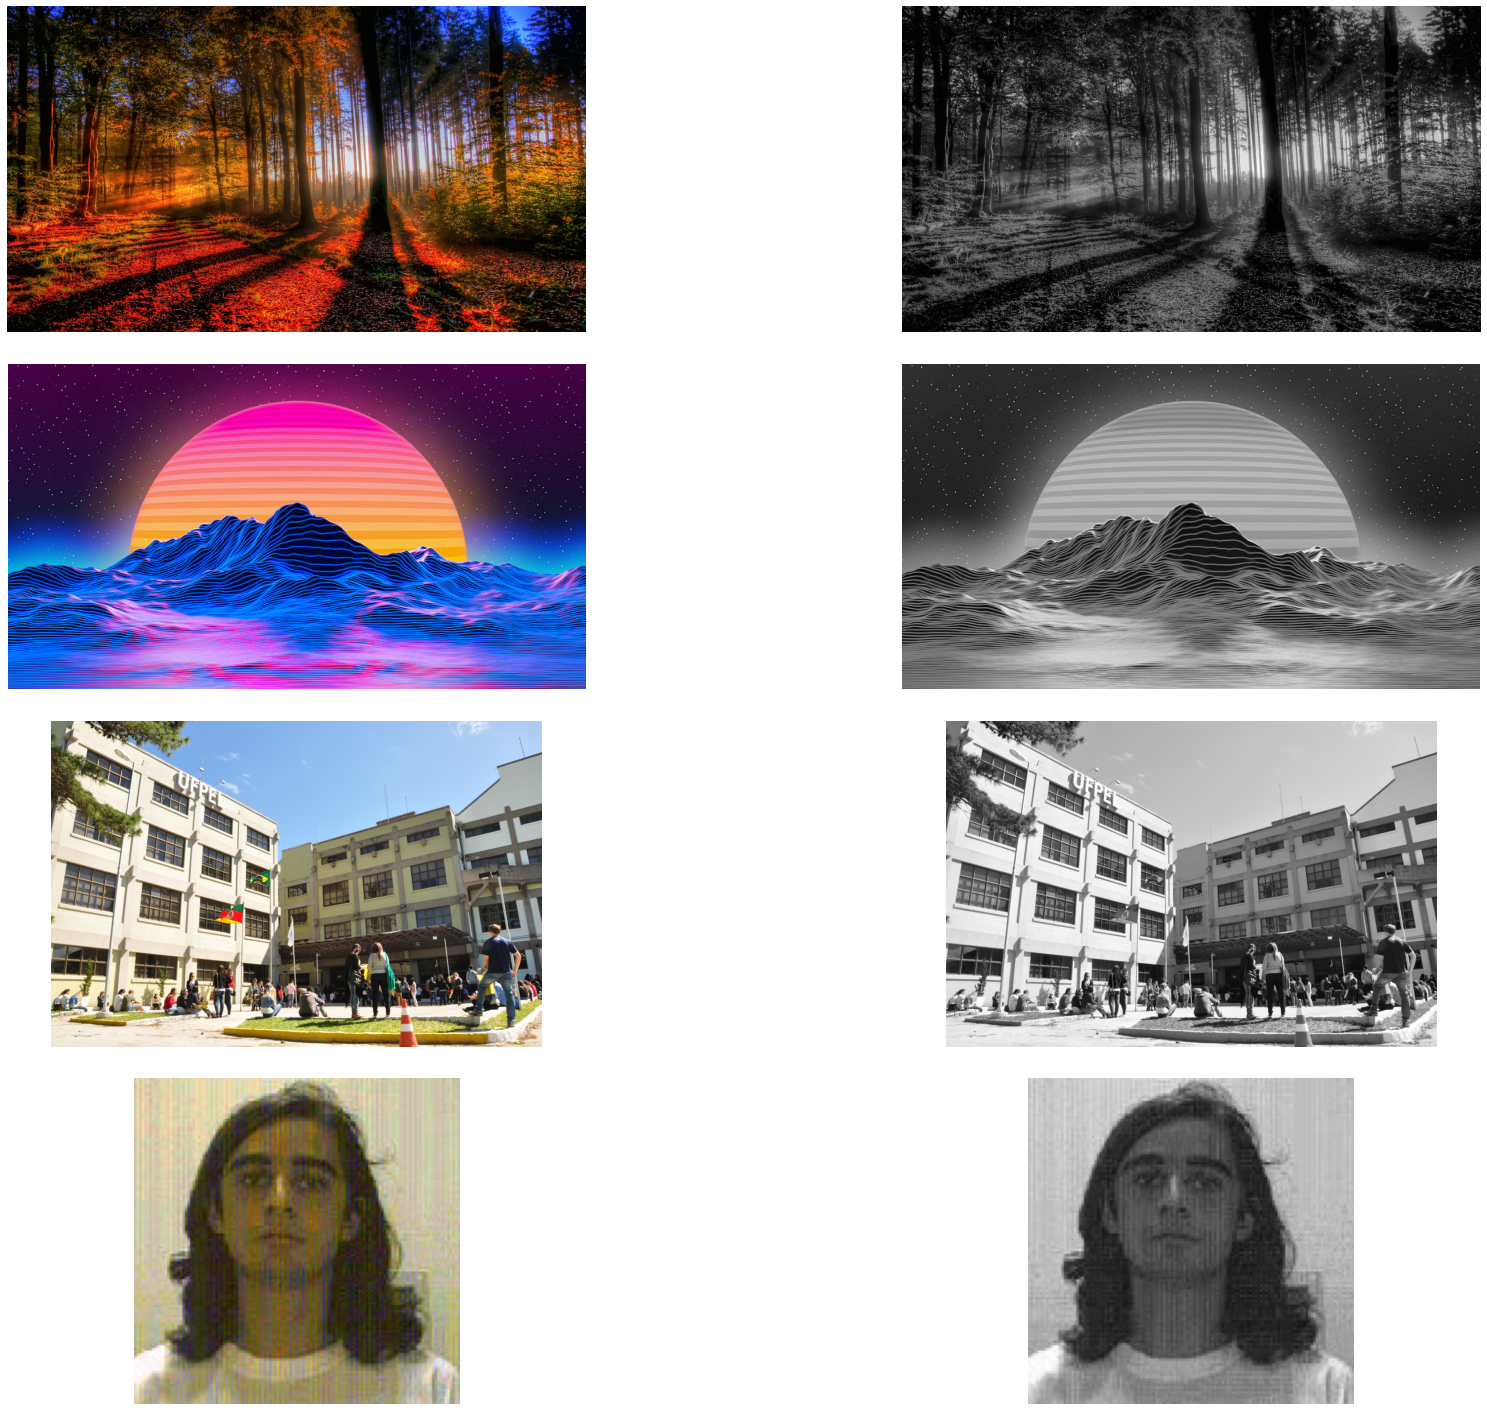

In [ ]:
# python script to display images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('example_image_0.png')
img2 = mpimg.imread('serial_grey_example_image_0.jpg')
img3 = mpimg.imread('example_image_1.jpg')
img4 = mpimg.imread('serial_grey_example_image_1.jpg')
img5 = mpimg.imread('example_image_2.jpg')
img6 = mpimg.imread('serial_grey_example_image_2.jpg')
img7 = mpimg.imread('example_image_3.jpg')
img8 = mpimg.imread('serial_grey_example_image_3.jpg')

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2,figsize=(25,20))
fig.tight_layout()

ax1.imshow(img1)
ax1.axis('off')
ax2.imshow(img2)
ax2.axis('off')
ax3.imshow(img3)
ax3.axis('off')
ax4.imshow(img4)
ax4.axis('off')
ax5.imshow(img5)
ax5.axis('off')
ax6.imshow(img6)
ax6.axis('off')
ax7.imshow(img7)
ax7.axis('off')
ax8.imshow(img8)
ax8.axis('off')

plt.axis('off')
plt.show()

##Implementação em CUDA

In [ ]:
%%writefile greyscale_cuda.cu

#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <algorithm>

#define STB_IMAGE_IMPLEMENTATION
#include "stb/stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"


__global__
void to_greyscale(uint8_t* img, unsigned char* img_grey, int height, int width, int channels) {
    int index_x = blockIdx.x * blockDim.x + threadIdx.x;
    int index_y = blockIdx.y * blockDim.y + threadIdx.y;

    if(index_x < width && index_y < height) {
        int grey_offset = index_y * width + index_x;
        int rgb_offset = grey_offset * channels;

        unsigned char r = img[rgb_offset ];
        unsigned char g = img[rgb_offset + 1];
        unsigned char b = img[rgb_offset + 2];

        img_grey[grey_offset] = 0.21f*r + 0.71f*g + 0.07f*b;
    }
}

int main(int argc, char** argv) {
    if(argc < 3) {
        printf("Usage: ./greyscale_cuda <input_image_file> <output_image_file.jpg>\n");
        exit(1);
    }

    // load image

    int width, height, channels, channels_try;

    channels_try = 3;

    uint8_t *img;

    img = stbi_load(argv[1], &width, &height, &channels, channels_try);

    if(channels != channels_try) {
        channels_try = 4;
        img = stbi_load(argv[1], &width, &height, &channels, channels_try);
    }
    
    size_t img_size = width * height * channels;
    
    printf("%d\t%d\t%d\n", width, height, channels);


    // allocate grey image

    int grey_channels;

    grey_channels = 1;

    size_t img_grey_size = width * height * grey_channels;
 
    unsigned char *img_grey = (unsigned char *) malloc(img_grey_size);
    if(img_grey == NULL) {
        printf("Unable to allocate memory for the grey image.\n");
        exit(1);
    }

    // calculate grey values

    uint8_t *img_cuda;
    unsigned char *img_grey_cuda;

    const int thread = 16;
    const dim3 blockSize(thread, thread, 1);
    const dim3 gridSize(height, width, 1);

    cudaMalloc(&img_cuda, img_size);
    cudaMemcpy(img_cuda, img, img_size, cudaMemcpyHostToDevice);

    cudaMalloc(&img_grey_cuda, img_grey_size);
    cudaMemcpy(img_grey_cuda, img_grey, img_grey_size, cudaMemcpyHostToDevice);

    to_greyscale<<<gridSize, blockSize>>>(img_cuda, img_grey_cuda, height, width, channels_try);

    cudaDeviceSynchronize();

    cudaMemcpy(img_grey, img_grey_cuda, img_grey_size, cudaMemcpyDeviceToHost);

    stbi_write_jpg(argv[2], width, height, grey_channels, img_grey, 100);

    // free image
    
    cudaFree(img_cuda);
    cudaFree(img_grey_cuda);
    stbi_image_free(img);
    free(img_grey);

    return 0;
}

Writing greyscale_cuda.cu


In [ ]:
!nvcc greyscale_cuda.cu -lm -o greyscale_cuda
!ls -la | grep greyscale_cuda

stb/stb_image.h(4152): warning: variable "old_limit" was set but never used

stb/stb_image.h(5038): warning: variable "idata_limit_old" was set but never used

stb/stb_image.h(6778): warning: variable "out_size" was set but never used

stb/stb_image.h(6779): warning: variable "delays_size" was set but never used

-rwxr-xr-x 1 root root  829784 Nov 29 21:22 greyscale_cuda
-rw-r--r-- 1 root root    2601 Nov 29 21:22 greyscale_cuda.cu


In [ ]:
%%time
!./greyscale_cuda example_image_0.png cuda_grey_example_image_0.jpg

1920	1080	4
CPU times: user 8.44 ms, sys: 10.5 ms, total: 19 ms
Wall time: 1.03 s


In [ ]:
%%time
!./greyscale_cuda example_image_1.jpg cuda_grey_example_image_1.jpg

728	410	3
CPU times: user 4.18 ms, sys: 11.9 ms, total: 16.1 ms
Wall time: 229 ms


In [ ]:
%%time
!./greyscale_cuda example_image_2.jpg cuda_grey_example_image_2.jpg

4288	2848	3
CPU times: user 8.98 ms, sys: 14.2 ms, total: 23.1 ms
Wall time: 2.44 s


In [ ]:
%%time
!./greyscale_cuda example_image_3.jpg cuda_grey_example_image_3.jpg

128	128	3
CPU times: user 2.47 ms, sys: 13.9 ms, total: 16.4 ms
Wall time: 225 ms


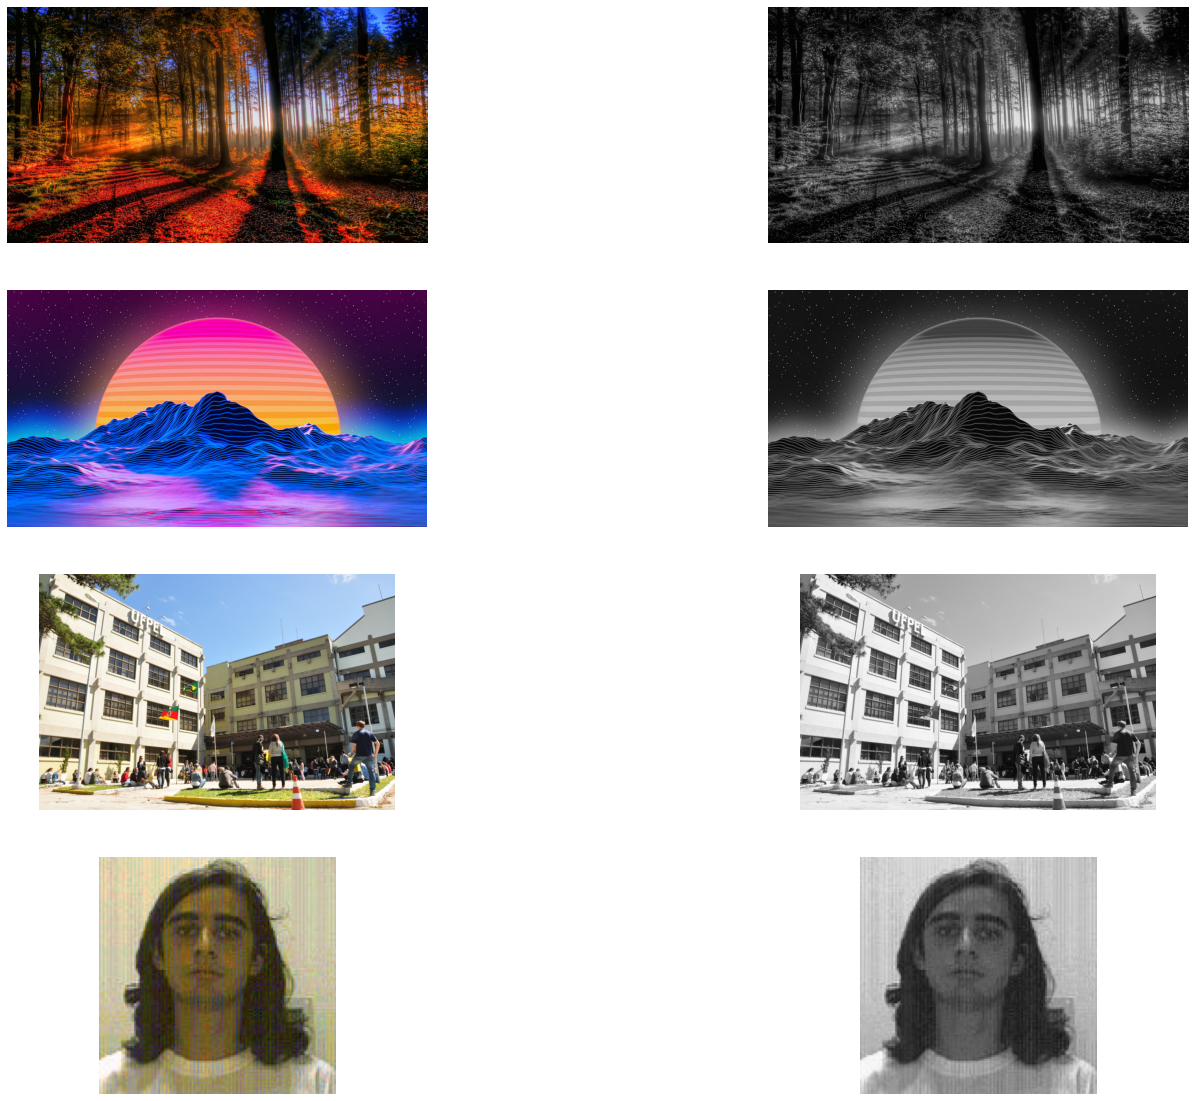

In [ ]:
# python script to display images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('example_image_0.png')
img2 = mpimg.imread('cuda_grey_example_image_0.jpg')
img3 = mpimg.imread('example_image_1.jpg')
img4 = mpimg.imread('cuda_grey_example_image_1.jpg')
img5 = mpimg.imread('example_image_2.jpg')
img6 = mpimg.imread('cuda_grey_example_image_2.jpg')
img7 = mpimg.imread('example_image_3.jpg')
img8 = mpimg.imread('cuda_grey_example_image_3.jpg')

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4,ncols=2,figsize=(25,20))

ax1.imshow(img1)
ax1.axis('off')
ax2.imshow(img2)
ax2.axis('off')
ax3.imshow(img3)
ax3.axis('off')
ax4.imshow(img4)
ax4.axis('off')
ax5.imshow(img5)
ax5.axis('off')
ax6.imshow(img6)
ax6.axis('off')
ax7.imshow(img7)
ax7.axis('off')
ax8.imshow(img8)
ax8.axis('off')

plt.axis('off')
plt.show()